<a href="https://colab.research.google.com/github/daniela-estevez/ProyectoIntegrador/blob/main/Avance2_13Equipo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Avance 2. Ingeniería de características

## Equipo 13

## Alejandro García Hernández A01793812
## Daniela Estevez Rodriguez A01793723
## Carlos Alberto López Álvarez A01168193

## Objetivos

Para esta etapa del proyecto, el objetivo es contar con una base óptima para que el(los) modelo(s) tengan el mejor rendimiento posible. Así, en esta etapa el trabajo se centra en seleccionar las variables que, a nuestro criterio, aporten mayor información, de ser necesesario se puede optar con construir nuevas características a partir de las ya existentes, reducir la cardinalidad de la base, etc. Con lo anterior, también se mitiga el riesgo de características sesgadas o correlacionadas y con ello, se puede acelerar la convergencia de los modelos seleccionados.

### 1. Depuración de características

In [21]:
#librerias a utilizar

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
# El siguiente bloque se agregó para poder leer los archivos drive
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/Colab Notebooks/Proyecto Integrador

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/Colab Notebooks/Proyecto Integrador


In [2]:
data = pd.read_csv("base.csv",sep=",", encoding="latin1")
df= data.copy()

In [ ]:
# Para tener en mente la base inicial, observamos que cuenta con 380 renglones,
# 115 características y las etiquetas

print(f"Hay {df.shape[0]} filas y {df.shape[1]} columnas.")

Hay 380 filas y 116 columnas.


#### 1.1 Características irrelevantes por el origen de información contenida

Como se observó en el primer avance del proyecto existen algunas características que pueden eliminarse dado que el contenido de las mismas es irrelevante para el actual estudio. Dichas caracteristicas son:

-> Nombre y residencia. Ya que no dan información relevante.

-> fecha_nacimiento y fecha_1er_visita. Ya que esta información esta contenida en edad_1er_visita.

-> FECHA_INICIO_ACTUAL_EPISODIO. Ya que esta información está contenida en EDAD_INICIO_1er_EPISODIO.

In [5]:
#Eliminamos entonces estas características
df = df.drop(["Nombre","residencia","fecha_nacimiento","fecha_1er_visita","FECHA_INICIO_ACTUAL_EPISODIO"], axis=1)

#### 1.2 Características con datos faltantes

Se eliminarán todas las características que solo contengan valores nuelos

In [7]:
#Eliminamos las columnas vacias
df = df.dropna(axis=1, how='all')

Si bien, existen diversos métodos para imputar valores faltantes en la base, esta imputación es peligrosa y puede sesgar los resultados si se realiza en variables en donde la mayoría de sus resgistros reportan valores faltantes, ya que los datos imputados podrían no ser representativos de la verdadera distribución de los datos. Por lo anterior es conveniente eliminar aquellas características en donde al menos el 40% de sus valores son nulos.

In [9]:
# Calculamos el porcentaje de valores nulos en cada columna
null_percentage = (df.isnull().sum() / len(df)) * 100

# Con el sguiente código, se crea un DataFrame con los porcentajes de valores nulos
null_df = pd.DataFrame({'Columna': null_percentage.index, 'Porcentaje_Null': null_percentage.values})

# Filtramos el DataFrame para mantener solo las columnas donde el porcentaje de valores nulos sea menor al 40%
columnas_a_mantener = null_df[null_df['Porcentaje_Null'] < 40]['Columna']

# Filtramos el DataFrame original para mantener solo las columnas que queremos conservar
df = df[columnas_a_mantener]

In [10]:
#Observamos que hasta este momento hemos eliminado ya 44 características
print(f"Hay {df.shape[0]} filas y {df.shape[1]} columnas.")

Hay 380 filas y 72 columnas.


#### 1.3 Variables que reportan el mismo valor en todos sus registros

De igual forma, en el primer avance del proyecto, observamos variables que reportan un solo valor en todos los registros. Dado que estas características no aportarán ninguna información al modelo, deben de eliminarse

In [14]:
#Primero obtenemos las variables que reportan un solo valor y mostramos sus nombres
unique_counts = df.nunique()
columnas_a_eliminar = unique_counts[unique_counts == 1].index
columnas_a_eliminar

Index(['A4', 'CONDUCTA_SUICIDA_REMISION_TEMPRANA', 'B4', 'B6', 'B7', 'B9',
       'B11', 'B12', 'B13', 'B14', 'B14a', 'B14b', 'B14c', 'B15', 'B16',
       'B16a', 'B16b', 'B16c', 'B17', 'B19', 'B_tot'],
      dtype='object')

In [15]:
#y procedemos a elimnarlas de la base
df = df.drop(columns=columnas_a_eliminar)

In [16]:
#Observamos que ahora ya hemos eliminado 65 características
print(f"Hay {df.shape[0]} filas y {df.shape[1]} columnas.")

Hay 380 filas y 51 columnas.


### 2 Imputación de valores

Ahora, será importante imputar los valores faltantes en aquellas variables que no fueron eliminadas pero si contenían valores nulos en alguno de sus registros. Para las características categoricas y booleanas se imputará la moda, mientras que para las valores numericas la imputación será con la media.

In [27]:
# Imputar la moda a las variables numéricas
for columna in df.select_dtypes(include='number').columns:
    df[columna] = df[columna].fillna(df[columna].mean())

# Imputar la moda a las variables booleanas
for columna in df.select_dtypes(include='bool').columns:
    moda = df[columna].mode()[0]  # Calcular la moda
    df[columna] = df[columna].fillna(moda)

# Imputar la moda a las variables alfanuméricas
for columna in df.select_dtypes(include='object').columns:
    moda = df[columna].mode()[0]  # Calcular la moda
    df[columna] = df[columna].fillna(moda)

### 3 Reducción de dimensionalidad

Veremos si existe correlación entre las variables númericas que hemos conservado en la base, con la finalidad de que, en caso de que exista, reducir la dimensionalidad de la base transformando/agrupando las variables correlacionadas en una sola.

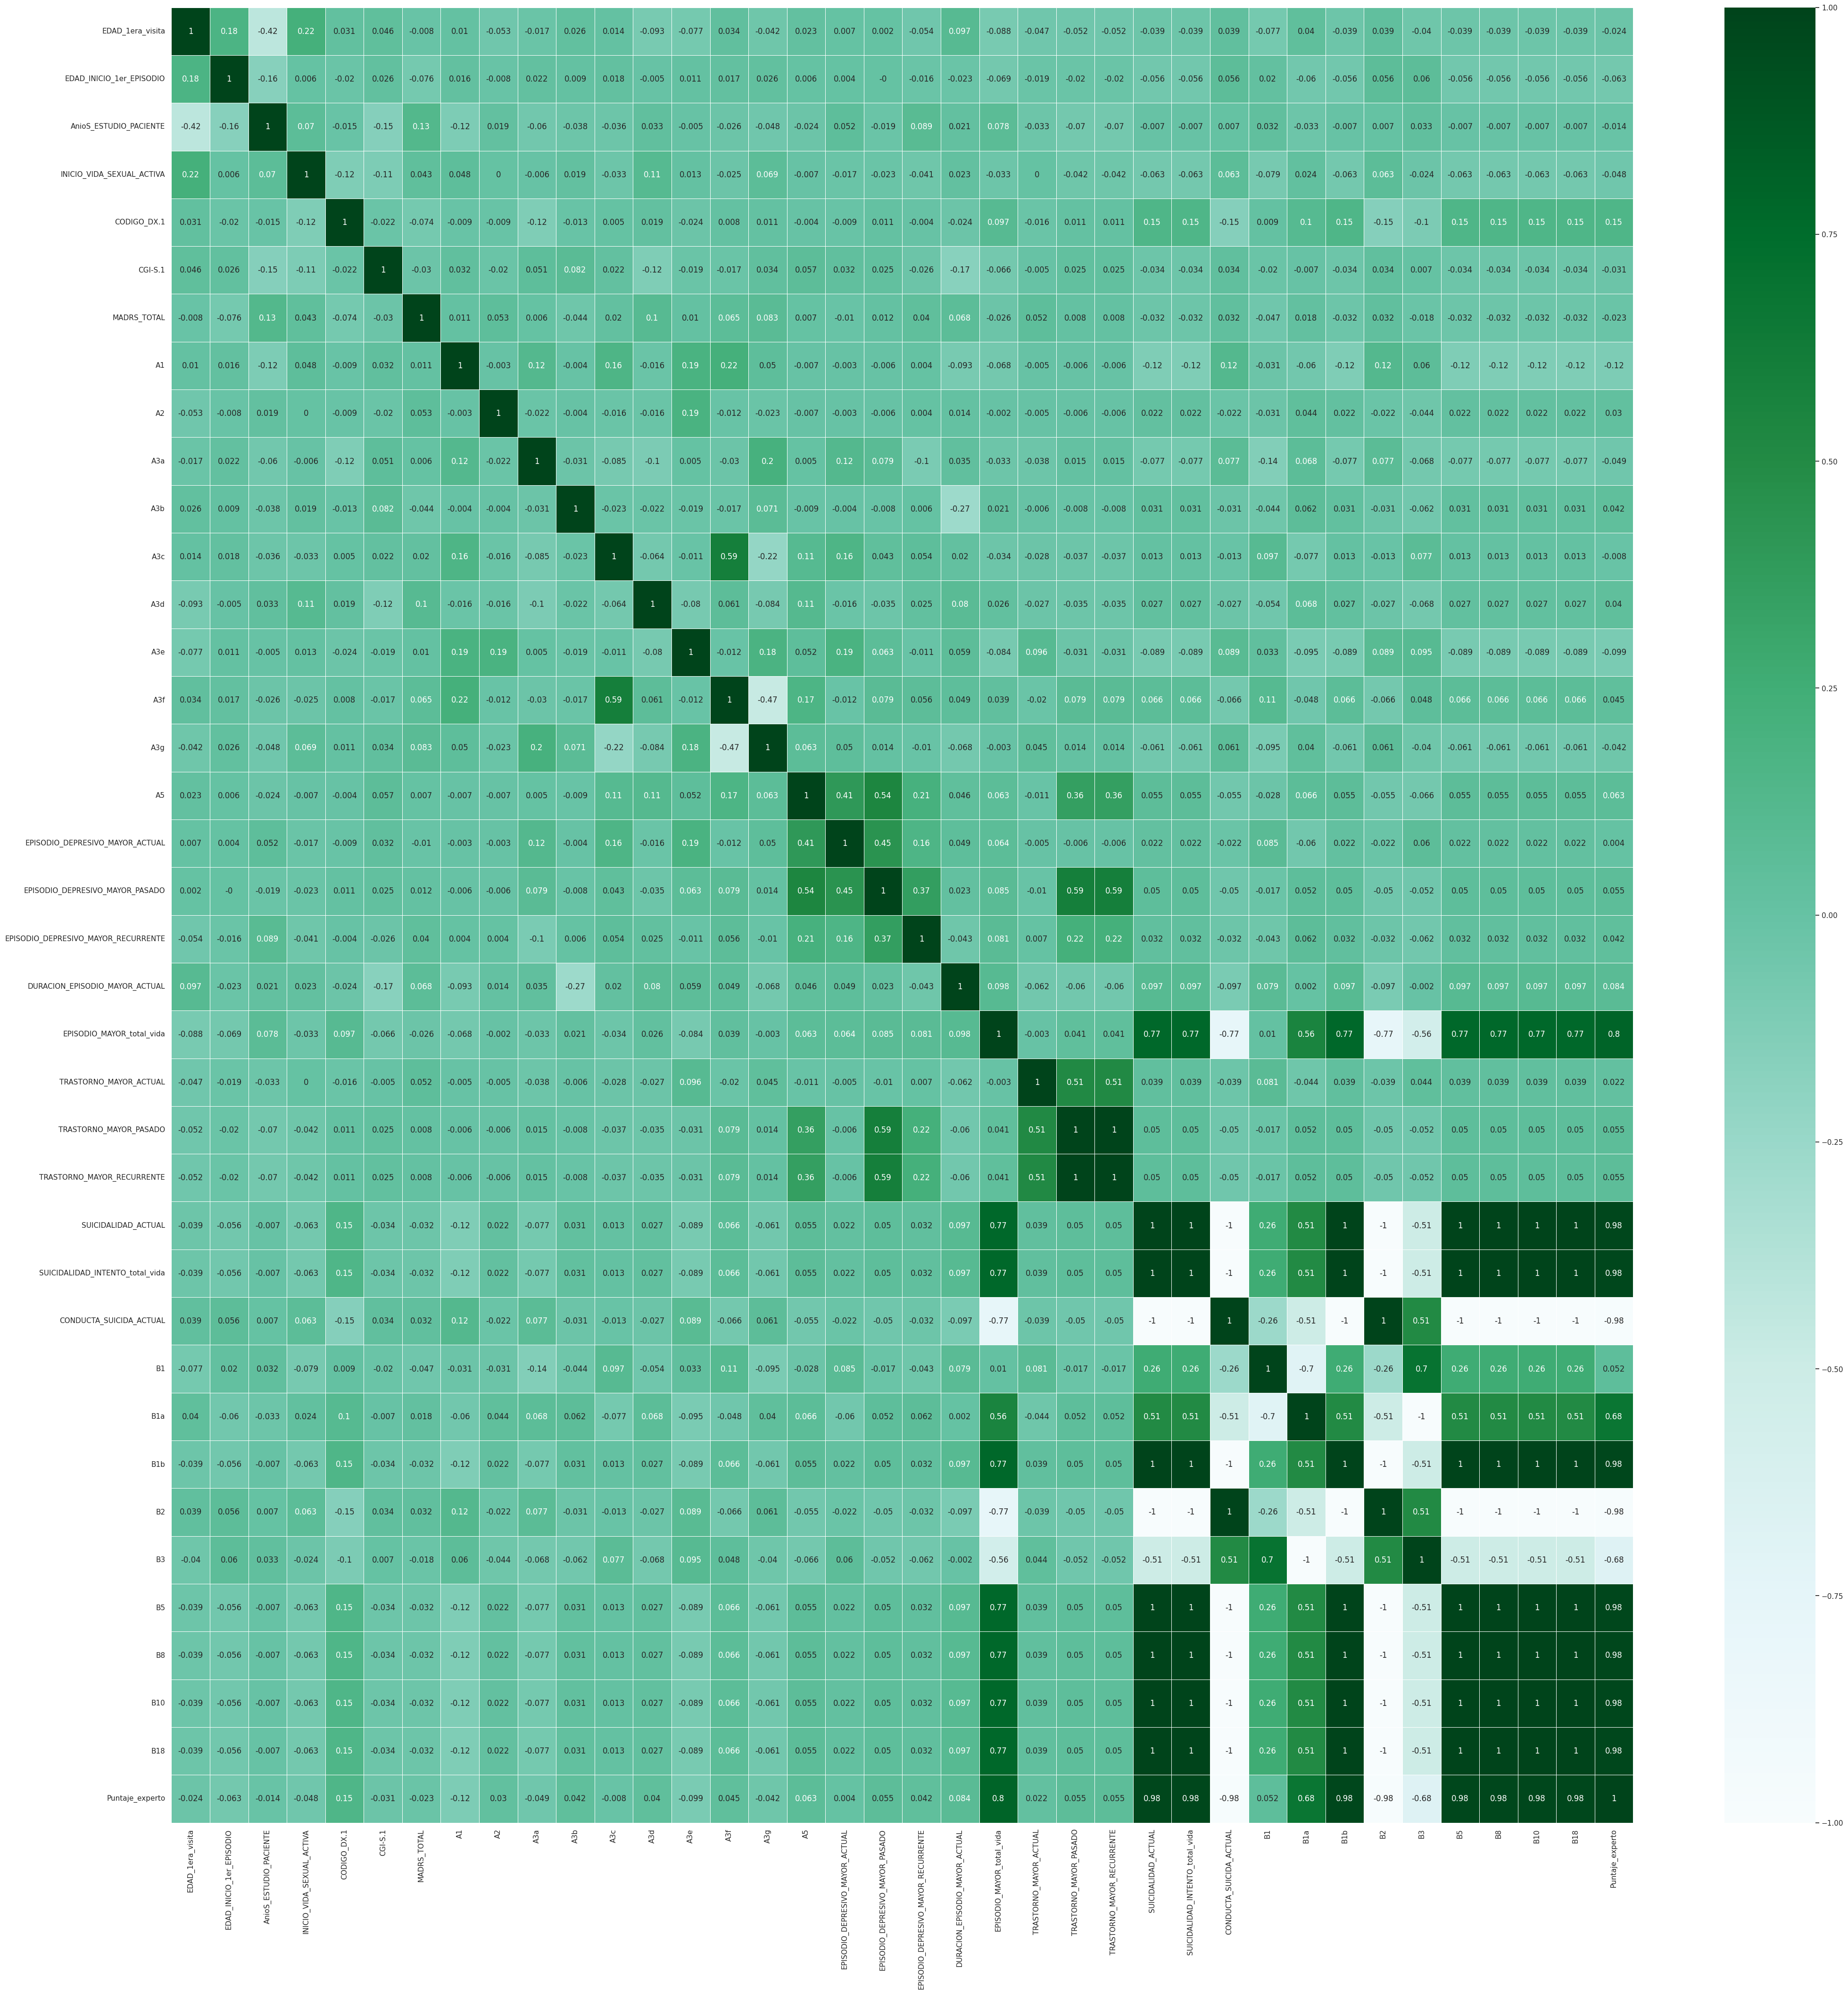

In [28]:
#Obtenemos las variables numéricas
numericas = df.select_dtypes(include=['float','int64'])

#Presentamos un heatmap con las correlaciones

sns.set(rc={'figure.figsize':(50,50)})

sns.heatmap(round(numericas.corr(),3), annot = True, cmap= 'BuGn', linewidths= 0.5)

plt.show()

Se observan que existen correlaciones altas, de hecho de 1, en varias caractarísticas. Si bien, podríamos utilizar un análisis de componentes principales para ver si podemos capturar a todas estas caractarísticas en una sola componente, observamos que todas estas variables tienen una correlación casi de 1 con la característica de "puntaje experto", se optó por dejar esta última en la base y eliminar el resto.

In [62]:
#Eliminamos entonces estas características
df = df.drop(["SUICIDALIDAD_ACTUAL","SUICIDALIDAD_INTENTO_total_vida","B1b","B5","B8","B10","B18"], axis=1)

In [61]:
#from sklearn.decomposition import PCA

#df_pca = df[["B5","B8","B10","B18"]]
# Usaremos un valor de 2 componentes
#pca = PCA(n_components=2)
#componentes_principales = pca.fit_transform(df_pca)

# Obtenemos los coeficientes de carga del primer componente principal
#coeficientes_de_carga_primer_componente = pd.DataFrame(pca.components_[0], index=df_pca.columns, columns=['Coeficiente_Carga'])

# Ahora ordenamos los coeficientes de carga en orden descendente
#coeficientes_de_carga_primer_componente = coeficientes_de_carga_primer_componente.abs().sort_values(by='Coeficiente_Carga', ascending=False)

# Finalmente mostramos las columnas con los coeficientes de carga más altos
#columnas_mejor_explicadas_por_primer_componente = coeficientes_de_carga_primer_componente.head()

#print(columnas_mejor_explicadas_por_primer_componente)

     Coeficiente_Carga
B10                0.5
B8                 0.5
B5                 0.5
B18                0.5


### 4. CONCLUSIONES


